In [40]:
import os
import tensorflow as tf
import keras 
from keras.optimizers import Adam
from keras.preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


train_dirname , test_dirname = '/home/kalyan/DataSets/DogsandCats/training_set/training_set/' , '/home/kalyan/DataSets/DogsandCats/test_set/test_set/'
train_filenames , test_filenames = [], []
train_labels , test_labels = [], []
for i in os.listdir(train_dirname):
    for j in os.listdir(train_dirname + i):
        train_filenames.append(train_dirname + i + '/' + j)
        train_labels.append(i)
for i in os.listdir(test_dirname):
    for j in os.listdir(test_dirname + i):
        test_filenames.append(test_dirname + i + '/' + j)
        test_labels.append(i)
        
def preprocess_image(filename, label):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.resize(image, [224, 224])
    image /= 255.0  # normalize to [0,1] range
    return image, label

train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames, train_labels))
train_dataset = train_dataset.map(preprocess_image)
train_dataset = train_dataset.shuffle(buffer_size=1000)
train_dataset = train_dataset.batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames, test_labels))
test_dataset = test_dataset.map(preprocess_image)
test_dataset = test_dataset.shuffle(buffer_size=1000)
test_dataset = test_dataset.batch(32)



In [41]:
import numpy as np
original_train_images = [train_dirname+i for i in os.listdir(train_dirname)] # use this for full dataset
train_dogs =   [train_dirname+i for i in os.listdir(train_dirname) if 'dog' in i]
train_cats =   [train_dirname+i for i in os.listdir(train_dirname) if 'cat' in i]

test_images =  [test_dirname+i for i in os.listdir(test_dirname)]


np.random.seed(1337)
# slice datasets for memory efficiency on Kaggle Kernels, delete if using full dataset
original_train_images = train_dogs[:12000] + train_cats[:12000]

#shuffle random images

# test_images =  test_images[:100]

# section = int(len(original_train_images) * 0.8)
train_images = original_train_images[:18000]
validation_images = original_train_images[18000:]

In [42]:
!lscpu | grep 'Core(s) per socket'

!lscpu | grep 'Thread(s) per core'

Core(s) per socket:              6
Thread(s) per core:              2


In [48]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                      shear_range = 0.2,    
                                        zoom_range = 0.2,
                                        horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_dirname,
                                                    target_size = (64, 64),
                                                    batch_size = 32,
                                                    class_mode = 'binary')

test_set = test_datagen.flow_from_directory(test_dirname,
                                                target_size = (64, 64),
                                                batch_size = 32,
                                                class_mode = 'binary')

from keras.applications import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

conv_base.summary()

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

      


Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
58889256/58889256 [==============================] - 64s 1us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32,

In [49]:
import albumentations as alb

augmentor = alb.Compose([alb.RandomCrop(width=150, height=150), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)])

#a fun which takes image as input and returns augmented image
def augment(image):
    image = tf.cast(image, tf.uint8)
    image = augmentor(image=image.numpy())['image']
    return image



#plot the augmented images
plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augment(images[0]))
        plt.axis("off")


AttributeError: 'DirectoryIterator' object has no attribute 'take'

<Figure size 1000x1000 with 0 Axes>

In [50]:
#plot the normalized images
plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1):
    for i in range(9):
        augmented_image = augment(images[0])
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image / 255.0)
        plt.axis("off")

AttributeError: 'DirectoryIterator' object has no attribute 'take'

<Figure size 1000x1000 with 0 Axes>

In [51]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3),kernel_regularizer='l2'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu' ),
    tf.keras.layers.MaxPooling2D(2,2), 
    

    tf.keras.layers.Conv2D(64, (3,3), activation='relu' ),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(150, activation='relu' ),
    
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model.summary()

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)      

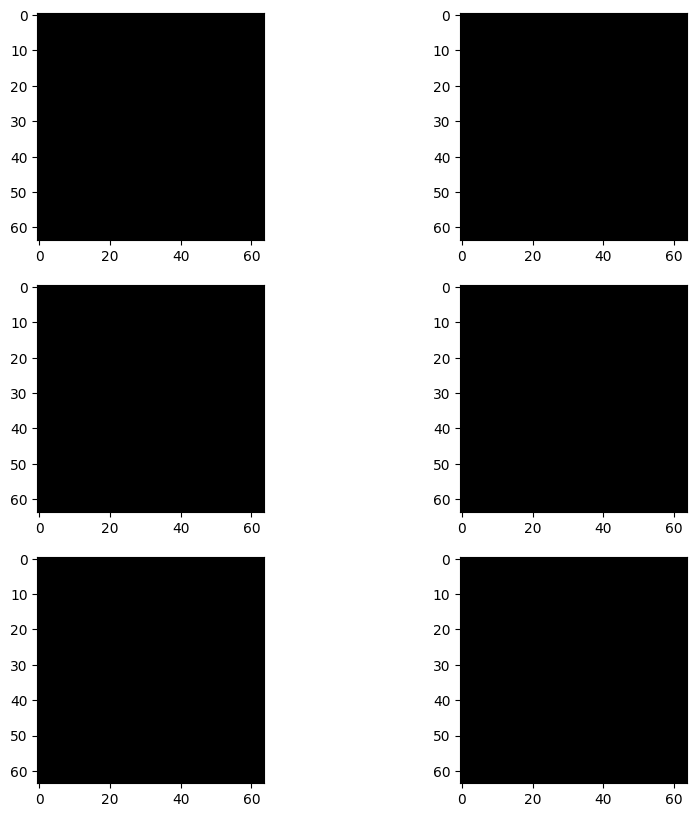

In [44]:

normalization_layer = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomRotation(0.5)
])

madness, labelledbs = next(iter(training_set))
madness = madness[3]
plt.figure(figsize=(10, 10))
for i in range(6):
    augmen = normalization_layer(madness)
    plt.subplot(3, 2, i + 1)
    plt.imshow(augmen)

In [8]:
augmented_image = data_augmentation(images)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[i].numpy().astype("uint8"))
    plt.axis("off")

NameError: name 'data_augmentation' is not defined

In [52]:

history = model.fit(
    training_set,
   test_set,
    epochs=15)


ValueError: `y` argument is not supported when using `keras.utils.Sequence` as input.

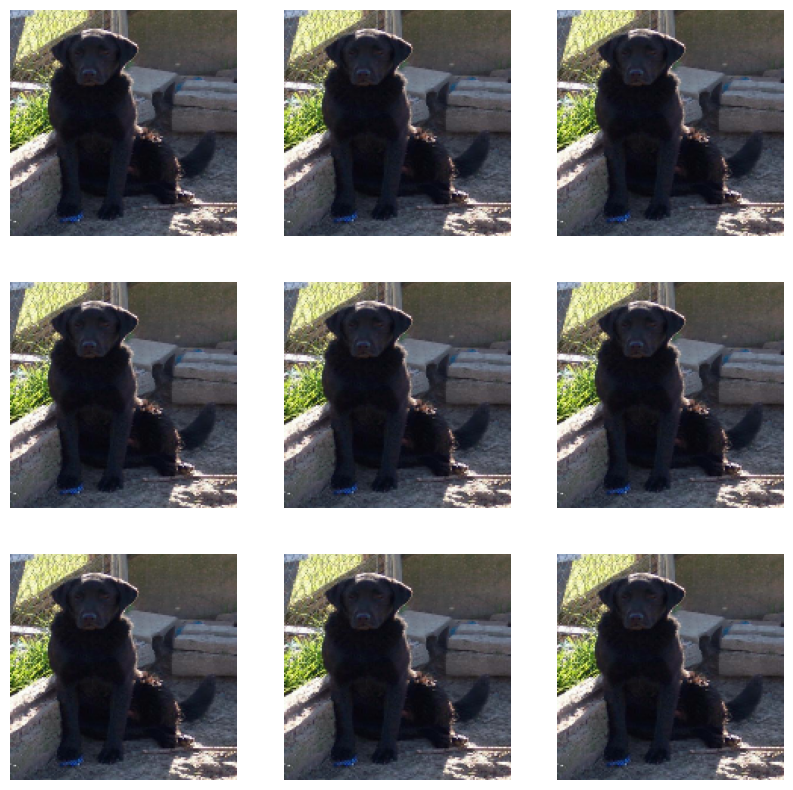

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
])


plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(train_ds)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

ValueError: Exception encountered when calling layer "random_rotation_17" "                 f"(type RandomRotation).

Attempt to convert a value (<BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>) with an unsupported type (<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>) to a Tensor.

Call arguments received by layer "random_rotation_17" "                 f"(type RandomRotation):
  • inputs=<BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
  • training=False

<Figure size 1000x1000 with 0 Axes>

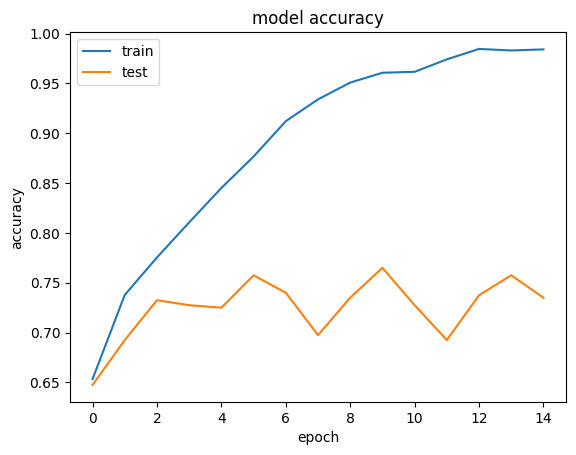

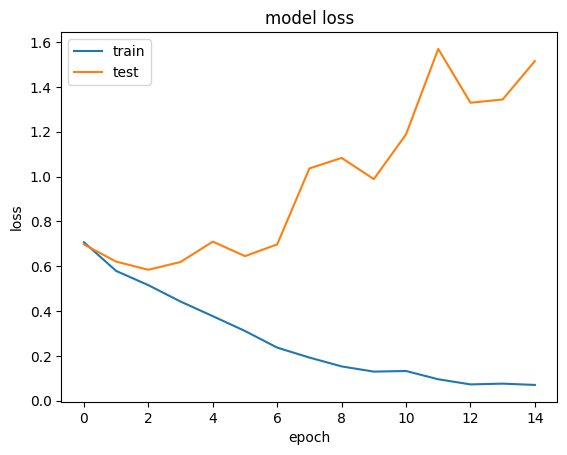

In [ ]:
#plot accuracy and loss
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
plt.figure(1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
